# News Article Classification

We collected 543 news article from CBC News from 19th September to 4th October. Each news article belongs to one of the five categories: business, entertainment, health, politics, or technology. In this notebook, our goal is to classify the news articles based on their content.

(The code for the web scraping process can be found [here](https://github.com/peterchoholam/News-Article-Classification/blob/master/cbc_scrap.py))

## Major Updates (Last Version: 24 Sep)

1. Larger Dataset
2. Improved Visualization
3. Further Analysis using Basic Characteristics and LSTM

## Outline

1. Data Preparation
2. Exploratory Data Analysis
3. Text Classification with Basic Characteristics
4. Text Classification with Bag-of-Words
5. Text Classification with Long Short-Term Memory

## Data Preparation

In [1]:
import pandas as pd
import spacy # For natural language processing
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from textblob import TextBlob # For polarity and subjectivity measure

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Word frequency counter
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence

np.random.seed(123)
%matplotlib inline
sns.set()
pd.options.display.max_rows = 10

First of all, we will load our dataset.

In [2]:
df = pd.read_csv('news.csv', index_col=0)
df

,title,content,category
0,Michigan warns about mosquito-borne virus afte...,Public health officials are urging people to g...,health
1,"Liberals pledge to boost Canada Child Benefit,...",The Liberals are promising a suite of family-f...,business
2,Hundreds join student's climate-change pledge:...,An 18-year-old McGill University student pledg...,technology
3,"Purdue Pharma, maker of OxyContin, files for b...","Purdue Pharma, the company that made billions ...",health
4,'Not one shred of scientific evidence': Critic...,When a Vancouver-area mother read a psychologi...,health
...,...,...,...
538,'Charming persistence:' Biblioasis founder tal...,When Dan Wells read Lucy Ellmann's latest nove...,entertainment
539,Justin Bieber and Hailey Baldwin marry for sec...,Justin Bieber and Hailey Baldwin tied the knot...,entertainment
540,New documentary profiles renowned Haida artist...,Anyone who has visited or lives on Canada's We...,entertainment
541,Opera legend Jessye Norman dies at 74,"Jessye Norman, the renowned international oper...",entertainment


There are 543 articles in total. For each article, the dataframe contains their title, content, and category. For example, let's take a look at the first news article in our dataset. (Public health officials are urging people to g...)

In [3]:
df.iloc[0,1]

"Public health officials are urging people to guard against mosquito bites after more cases of a rare mosquito-borne virus, including two additional deaths in southwestern Michigan.  The Michigan Department of Health and Human Services issued an update Tuesday on Eastern equine encephalitis, saying there were deaths in Cass and Van Buren counties. Those follow an earlier death in Kalamazoo County.    There also have been human cases in Barry and Berrien counties, and animal cases in St. Joseph, Genesee and Lapeer counties. In all, Michigan has had seven confirmed human cases and nine horse deaths.  The department is encouraging officials in affected counties to consider postponing, rescheduling or cancelling outdoor activities occurring at or after dusk, particularly activities that involve children, until there's a hard frost.   The virus is rare but dangerous, and symptoms include fever, chills and muscle and joint pain. It can cause inflammation and swelling in the brain.   Accordin

In natural language processing, before we analyze a text, there are a few fundamental steps:
1. remove stop words, e.g. a, an, the
2. remove punctuations
3. change every word to lower case
4. lemmatize, e.g. run/runs/ran/running are considered the same

We will use the python library `spaCy` to achieve this goal. At the same time, we will record the length of each article as well as the name entities that the article uses (name, location, number, date, etc.)

In [4]:
nlp = spacy.load('en_core_web_md') # This model comes with pre-trained GloVe vectors
punct = [char for char in string.punctuation] # All punctuations

nlp.Defaults.stop_words.add("ll") # Add the stop word "ll" to spaCy's list of stop words
nlp.Defaults.stop_words.add("ve") # Add the stop word "ve" to spaCy's list of stop words

def info(row):
    text_tokenized = [w.lemma_.lower() for w in nlp(row['content']) # Lemmatize and change to lower case
                      if w.is_stop==False # Remove stop words
                      and w.text not in punct] # Remove punctuations
    
    # Length of Text
    row['length'] = len(text_tokenized)
    
    # Text after cleaning
    string = ""
    for word in text_tokenized:
        string = string + " " + word # collect the words to form the text again

    row['content cleaned'] = string
    
    # Name Entity Recognition
    en = []
    for ents in nlp(row['content']).ents:
        en.append(ents.label_)
    
    row['entity'] = en

    return row

# Apply this to every article and create three new columns
df = df.apply(info, axis=1)

In [5]:
df.head()

,title,content,category,length,content cleaned,entity
0,Michigan warns about mosquito-borne virus afte...,Public health officials are urging people to g...,health,114,public health official urge people guard mosq...,"[CARDINAL, GPE, ORG, DATE, ORG, PERSON, GPE, G..."
1,"Liberals pledge to boost Canada Child Benefit,...",The Liberals are promising a suite of family-f...,business,308,liberals promise suite family friendly benefi...,"[NORP, ORG, PERSON, DATE, TIME, GPE, PERSON, M..."
2,Hundreds join student's climate-change pledge:...,An 18-year-old McGill University student pledg...,technology,325,18-year old mcgill university student pledge ...,"[ORG, NORP, CARDINAL, PERSON, ORG, WORK_OF_ART..."
3,"Purdue Pharma, maker of OxyContin, files for b...","Purdue Pharma, the company that made billions ...",health,330,purdue pharma company billion sell prescripti...,"[ORG, CARDINAL, PRODUCT, GPE, GPE, DATE, MONEY..."
4,'Not one shred of scientific evidence': Critic...,When a Vancouver-area mother read a psychologi...,health,438,vancouver area mother read psychologist recom...,"[GPE, PERSON, ORG, ORG, GPE, LOC, CARDINAL, GP..."


We can look at the article about mosquito bites again to see what's changed.

In [6]:
df.iloc[0,3]

114

In the `entity` column, we record the type of name entities contained in the text. [Here](https://spacy.io/api/annotation#named-entities) contains the explanation for the annotations. For example,

`PERSON` = People, including fictional.

`NORP` = Nationalities or religious or political groups.

`FAC` = Buildings, airports, highways, bridges, etc.

`ORG` = Companies, agencies, institutions, etc.

In [7]:
entity_list = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LAW', 'LANGUAGE', 'DATA', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']

def check(LIST, ELE):
    return LIST.count(ELE)

for word in entity_list:
    df[word] = df['entity'].apply(lambda entity: check(entity, word))

In [8]:
df.head()

,title,content,category,length,content cleaned,entity,PERSON,NORP,FAC,ORG,...,WORK_OF_ART,LAW,LANGUAGE,DATA,TIME,PERCENT,MONEY,QUANTITY,ORDINAL,CARDINAL
0,Michigan warns about mosquito-borne virus afte...,Public health officials are urging people to g...,health,114,public health official urge people guard mosq...,"[CARDINAL, GPE, ORG, DATE, ORG, PERSON, GPE, G...",2,0,0,3,...,0,0,0,0,0,0,1,0,0,5
1,"Liberals pledge to boost Canada Child Benefit,...",The Liberals are promising a suite of family-f...,business,308,liberals promise suite family friendly benefi...,"[NORP, ORG, PERSON, DATE, TIME, GPE, PERSON, M...",8,6,0,18,...,0,0,0,0,1,0,6,0,0,3
2,Hundreds join student's climate-change pledge:...,An 18-year-old McGill University student pledg...,technology,325,18-year old mcgill university student pledge ...,"[ORG, NORP, CARDINAL, PERSON, ORG, WORK_OF_ART...",14,2,1,3,...,2,0,0,0,1,0,0,0,1,3
3,"Purdue Pharma, maker of OxyContin, files for b...","Purdue Pharma, the company that made billions ...",health,330,purdue pharma company billion sell prescripti...,"[ORG, CARDINAL, PRODUCT, GPE, GPE, DATE, MONEY...",8,2,0,8,...,0,0,0,0,0,0,7,0,0,4
4,'Not one shred of scientific evidence': Critic...,When a Vancouver-area mother read a psychologi...,health,438,vancouver area mother read psychologist recom...,"[GPE, PERSON, ORG, ORG, GPE, LOC, CARDINAL, GP...",11,1,0,10,...,0,6,0,0,0,0,3,0,0,1


We will also employ the python library `textblob` to study the polarity and subjectivity of the news during our exploratory data analysis.

In [9]:
df['polarity'] = df['content'].map(lambda text: TextBlob(text).sentiment.polarity)
df['subjectivity'] = df['content'].map(lambda text: TextBlob(text).sentiment.subjectivity)

## Exploratory Data Analysis

Next, we will begin our exploratory data analysis. The first thing we do is to check the distribution of the five categories.

In [10]:
pd.value_counts(df['category'])

politics         135
technology       110
business         104
health           100
entertainment     94
Name: category, dtype: int64

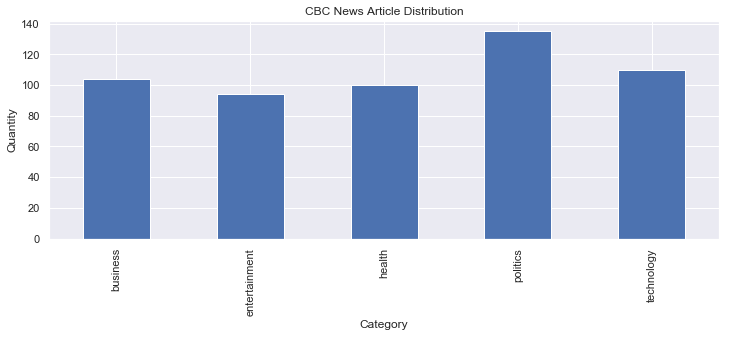

In [11]:
import matplotlib.pyplot as plt

df.groupby('category')['title'].nunique().plot(kind='bar', figsize=(12,4));
plt.ylabel('Quantity')
plt.xlabel('Category')
plt.title('CBC News Article Distribution');

We have roughly the same number of articles for each category, which is a good sign for multi-class classification problem. Unsurprisingly, the number of political news is slightly higher since the federal election is coming!

Next, we will calculate the frequency of words in the news articles. Normally, news articles from different categories would use a very different set of vocabularies, and this is very helpful in classification.

In [12]:
def words_count(category, n):
    text = df['content cleaned'][df['category']==category] # pick out a certain category
    vec = CountVectorizer(stop_words=nlp.Defaults.stop_words, ngram_range=(n,n)).fit(text)
    bag = vec.transform(text) # count the words distribution for each text
    sum_words = bag.sum(axis=0) # sum the distribution for all of the texts in that category
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] 
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Our function `words_count` takes two inputs. The first one is the category we want to measure (e.g. politics), and the second one is the length of the phrases we want to count. And here is our plotting function:

In [13]:
def freq_plot(category, n):
    label, value = zip(*words_count(category, n)[:15])
    index = np.arange(len(label))
    plt.figure(figsize=(12,5))
    plt.bar(index, value)
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    plt.xticks(index, label, fontsize=12, rotation=60)
    plt.title('The 15 most frequent words/phrases with length ' + str(n) + ' (' + category + ')');

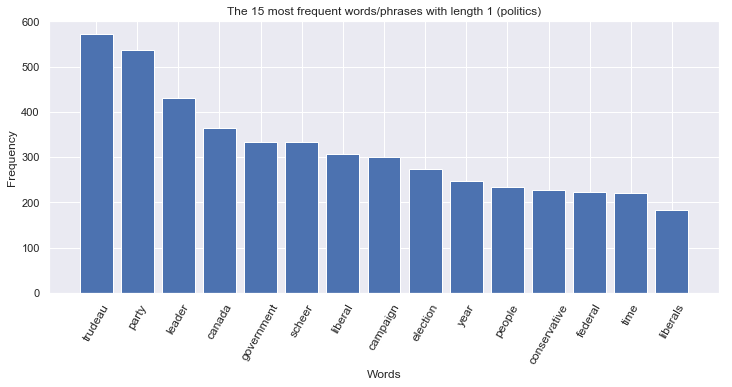

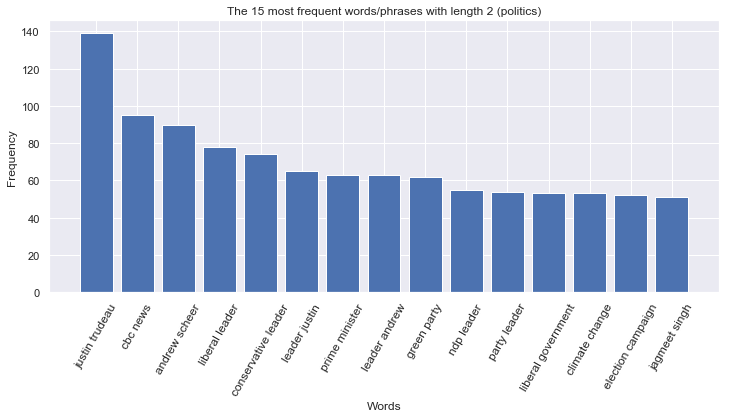

In [14]:
freq_plot('politics', 1) # 15 most frequent words in politics
freq_plot('politics', 2) # 15 most frequent phrases/2-grams in politics

As the Canadian federal election is getting closer, the leaders of various political parties come up a lot in the charts (e.g. Justin Trudeau, Andrew Scheer). The word "trudeau" alone already appeared around 560 times.

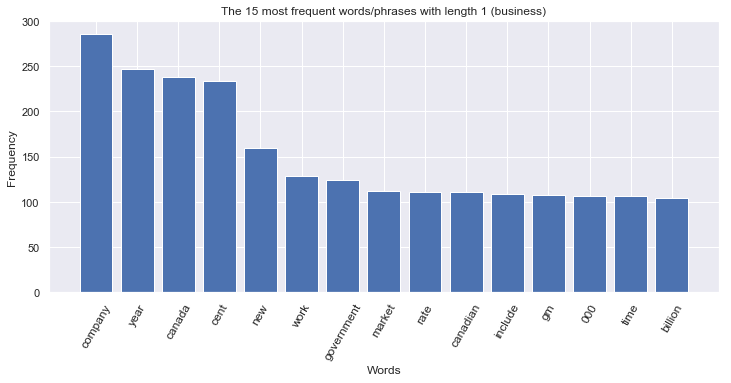

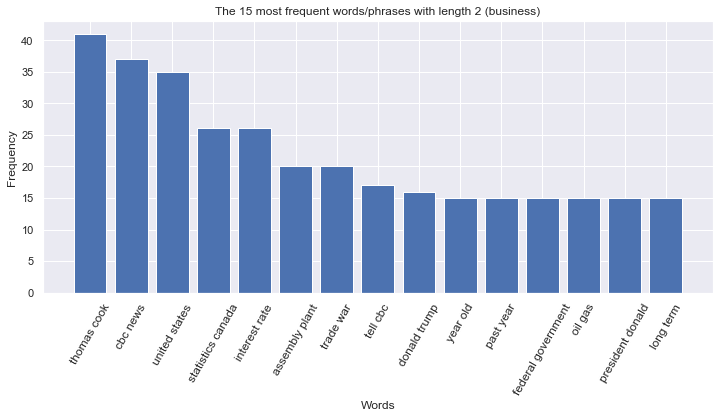

In [15]:
freq_plot('business', 1) # 15 most frequent words in business
freq_plot('business', 2) # 15 most frequent phrases/2-grams in business

The sudden bankruptcy of the British travel operator Thomas Cook is probably the biggest news right now. By the way, the popular word "gm" refers to General Motors, a company in the United States and there is an ongoing strike recently.

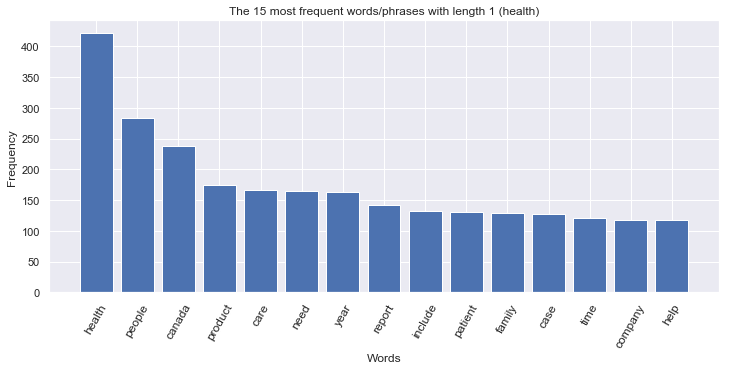

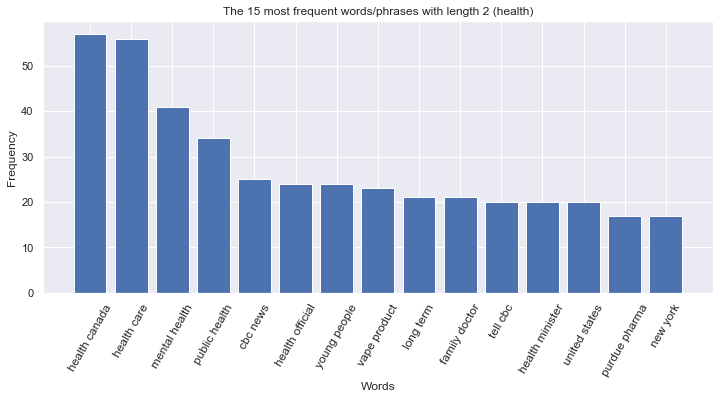

In [16]:
freq_plot('health', 1) # 15 most frequent words in business
freq_plot('health', 2) # 15 most frequent phrases/2-grams in health

There is a general interest in public health issues, which is understandable since the election is happening soon and public healthcare policy is an important aspect of the platforms.

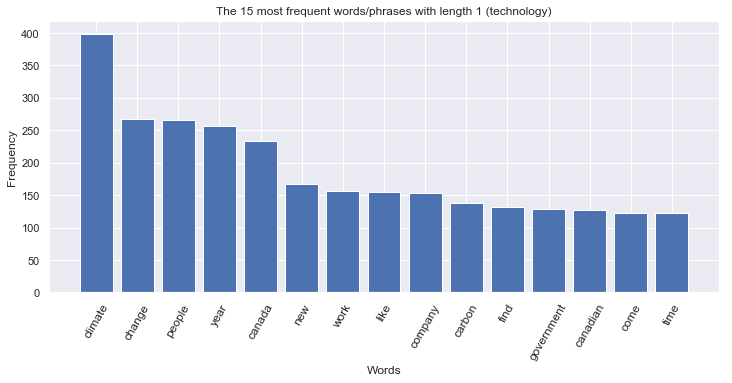

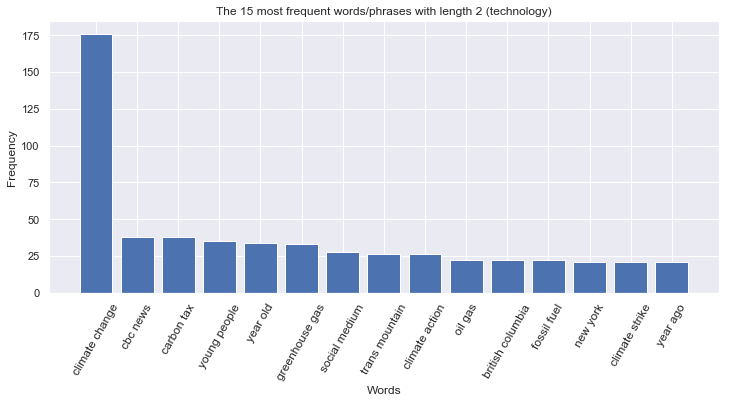

In [17]:
freq_plot('technology', 1) # 15 most frequent words in technolog
freq_plot('technology', 2) # 15 most frequent phrases/2-grams in technology

Climate change is certainly a hot topic because of the Global Climate Strike.

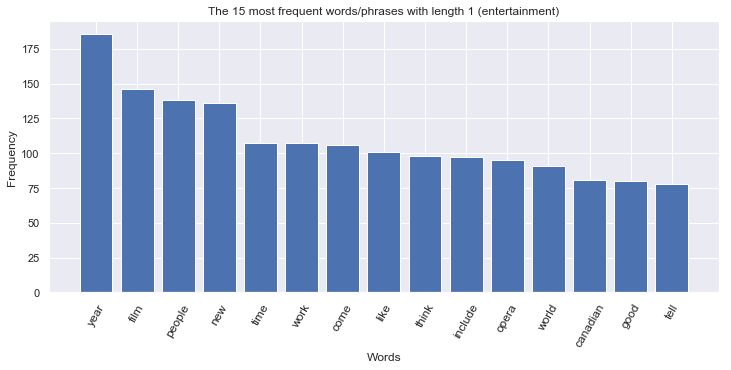

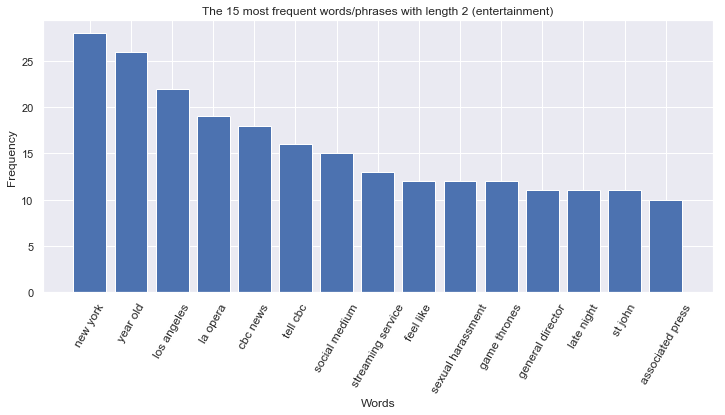

In [18]:
freq_plot('entertainment', 1) # 15 most frequent words in entertainment
freq_plot('entertainment', 2) # 15 most frequent phrases/2-grams in entertainment

Interestingly, two cities in the US (New York, Los Angeles) got a lot of coverage by a Canadian news agency.

Next, we look at the polarity measure. It is a number between 1 and -1. It indicates whether the news article is presenting a positive or negative message.

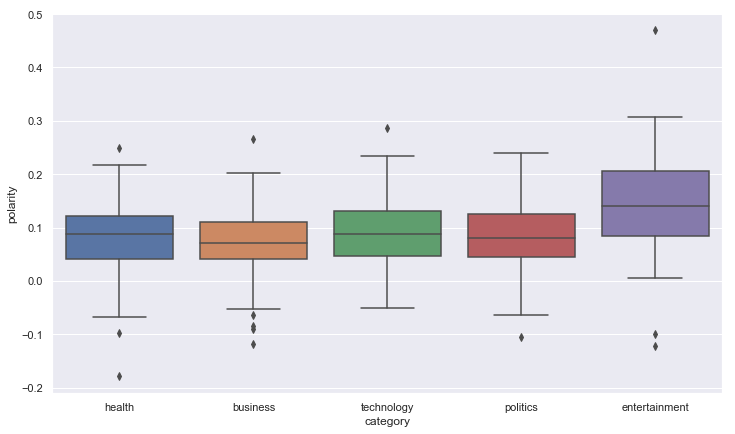

In [19]:
plt.figure(figsize=(12,7))
sns.boxplot(y=df.polarity, x=df.category);

From the graph, we can see that all the articles are essentially neutral. The most "extreme" article is from entertainment, which has a polarity score of around 0.5.

Here it is:

In [20]:
polarity_max = df['polarity'].max()
id_polarity_max = df.index[df['polarity']==polarity_max].tolist()[0]
df.iloc[id_polarity_max, 1]

'Celine Dion has postponed four of her Montreal shows due to a throat virus, according to a news release from concert promoter Evenko.  The shows, set for the Bell Centre on Sept. 26, 27, 30 and Oct. 1, have been moved to Nov. 18, 19, 21 and 22.  Dion is under "strict orders from her doctor" to rest for a week so she can make her scheduled appearances at the Bell Centre on Oct. 4 and 5.  Ticket holders for the affected shows will be automatically changed to the re-assigned dates.     Tickets for Thursday, Sept. 26 will now be good for Monday, Nov. 18.   Tickets for Friday, Sept. 27 will now be good for Tuesday, Nov. 19.   Tickets for Monday, Sept. 30 will now be good for Thursday, Nov. 21.   Tickets for Tuesday, Oct. 1 will now be good for Friday, Nov. 22.    Dion kicked off her first world tour in a decade with a performance at the Vidéotron Centre in Quebec City on Sept. 18.  The beloved Quebec icon is set to release her new album, Courage, on Nov. 15.'

It doesn't sound positive at all - maybe the multiple occurences of the word "good" in the article has misled the polarity measurement.

And here is the most "negative" article:

In [21]:
polarity_min = df['polarity'].min()
id_polarity_min = df.index[df['polarity']==polarity_min].tolist()[0]
df.iloc[id_polarity_min, 1]

'Some cooked diced chicken meat that was marketed under a number of brand names is being recalled due to possible Listeria contamination.  The Canadian Food Inspection Agency says the chicken was sold across the country by Tip Top Poultry Inc., Reuven International Ltd., Sysco and AlimPlus Inc.  It came in 4, 4.54 and 13.64 kilogram packages, all with the same pack date of July 29, 2019.  Anyone who has the chicken is advised to either throw it out or return it to the place of purchase.  There have been no reports of illness linked to the product.'

How about subjectivity? It will be a number between 0 and 1, and 1 means the news is very subjective. So let see.

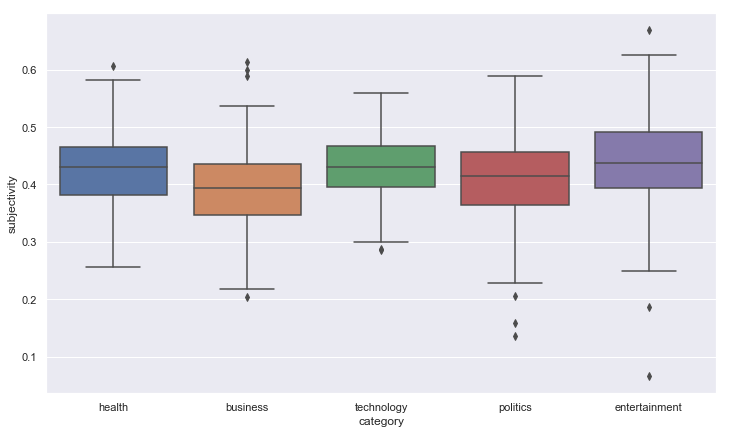

In [22]:
plt.figure(figsize=(12,7))
sns.boxplot(y=df.subjectivity, x=df.category);

This time, let's look at the most objective news here:

In [23]:
subjectivity_min = df['subjectivity'].min()
id_subjectivity_min = df.index[df['subjectivity']==subjectivity_min].tolist()[0]
df.iloc[id_subjectivity_min, 1]

'Twitter has removed a tweet from President Donald Trump that featured an edited Nickelback music video clip that took aim at former Vice President Joe Biden.  The post was removed because of a copyright complaint.  It had featured a doctored version of the Canadian band\'s 2005 music video Photograph, showing singer Chad Kroeger holding a photo of Biden, his son, an American business associate and another man.    Trump\'s tweet came as the president has repeatedly criticized Democrats for launching an impeachment inquiry into his telephone call with Ukraine\'s president in which Trump pressed for an investigation of his Democratic rival Biden and his son.  A Twitter spokeswoman said Thursday it responded "to valid copyright complaints sent to us by a copyright owner or their authorized representatives."  Nickelback representatives have not returned messages seeking comment.  '

Everything in here is plain fact. No wonder it is considered to be objective!

In [24]:
subjectivity_max = df['subjectivity'].max()
id_subjectivity_max = df.index[df['subjectivity']==subjectivity_max].tolist()[0]
df.iloc[id_subjectivity_max, 1]

"It's no joker. The night was lighting up around the world Saturday with the famous bat signal to mark a special anniversary for Batman.  DC Comics carried off a celebration of Batman Day to mark the 80th anniversary of the appearance of crimefighter Bruce Wayne and his masked identity.  Fan gatherings happened all over the world. But the most ambitious party plan was the illumination of the bat signal.  It started at Fed Square in Melbourne, Australia. It was also planned to appear in 13 other cities, including Montreal Tokyo, Berlin, Rome, Paris, London, Sao Paulo and Johannesburg.  In the U.S., it was to light up at the Domino Sugar Refinery in New York City before making its final appearance in Los Angeles at City Hall."

This article contains words like "famous", "special", and "ambitious". This is perhaps the reason why this article is on the subjective side.

We can also display the length distribution using a boxplot:

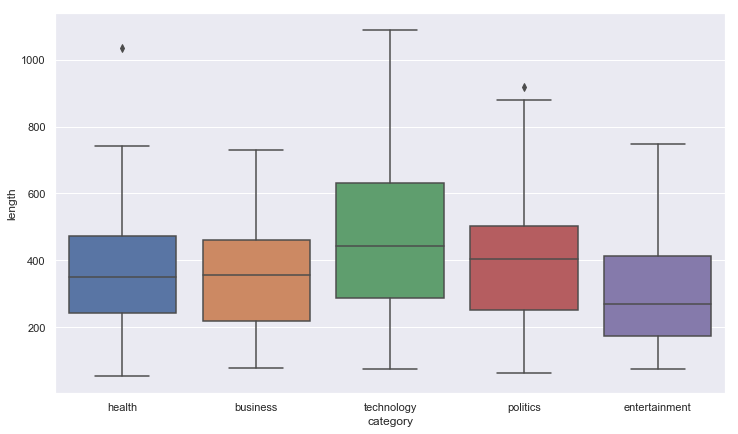

In [25]:
plt.figure(figsize=(12,7))
sns.boxplot(y=df.length, x=df.category);

Most articles have less than 600 words (we will use this fact when it comes to the LSTM part).

Previously, we have recorded the use of 18 different name entities in the articles. Together with length, polarity, and subjectivity, they provide some numerical information of our dataset. Here, we can look at some of the basic statistics:

In [26]:
df.describe()

,length,PERSON,NORP,FAC,ORG,GPE,LOC,PRODUCT,EVENT,WORK_OF_ART,...,LANGUAGE,DATA,TIME,PERCENT,MONEY,QUANTITY,ORDINAL,CARDINAL,polarity,subjectivity
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,...,543.000000,543.0,543.00000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,382.523020,12.883978,4.075506,0.425414,12.327808,8.948435,0.957643,0.427256,0.163904,0.467772,...,0.104972,0.0,1.13628,0.066298,2.248619,0.283610,1.046041,4.747698,0.091246,0.416493
std,192.571506,10.854089,5.383092,1.009849,9.199074,7.844729,2.431355,1.186390,0.567269,1.040850,...,0.506447,0.0,2.53460,0.290099,3.547110,0.991034,1.370383,4.465620,0.071376,0.073394
min,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.178125,0.066667
25%,231.000000,6.000000,0.000000,0.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,1.500000,0.049926,0.377915
50%,364.000000,10.000000,2.000000,0.000000,10.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00000,0.000000,1.000000,0.000000,1.000000,4.000000,0.085634,0.419771
75%,495.000000,17.000000,6.000000,0.000000,17.000000,12.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.0,1.00000,0.000000,3.000000,0.000000,2.000000,7.000000,0.131247,0.462379
max,1089.000000,68.000000,33.000000,8.000000,58.000000,52.000000,34.000000,12.000000,4.000000,10.000000,...,6.000000,0.0,20.00000,2.000000,26.000000,14.000000,8.000000,27.000000,0.470170,0.668872


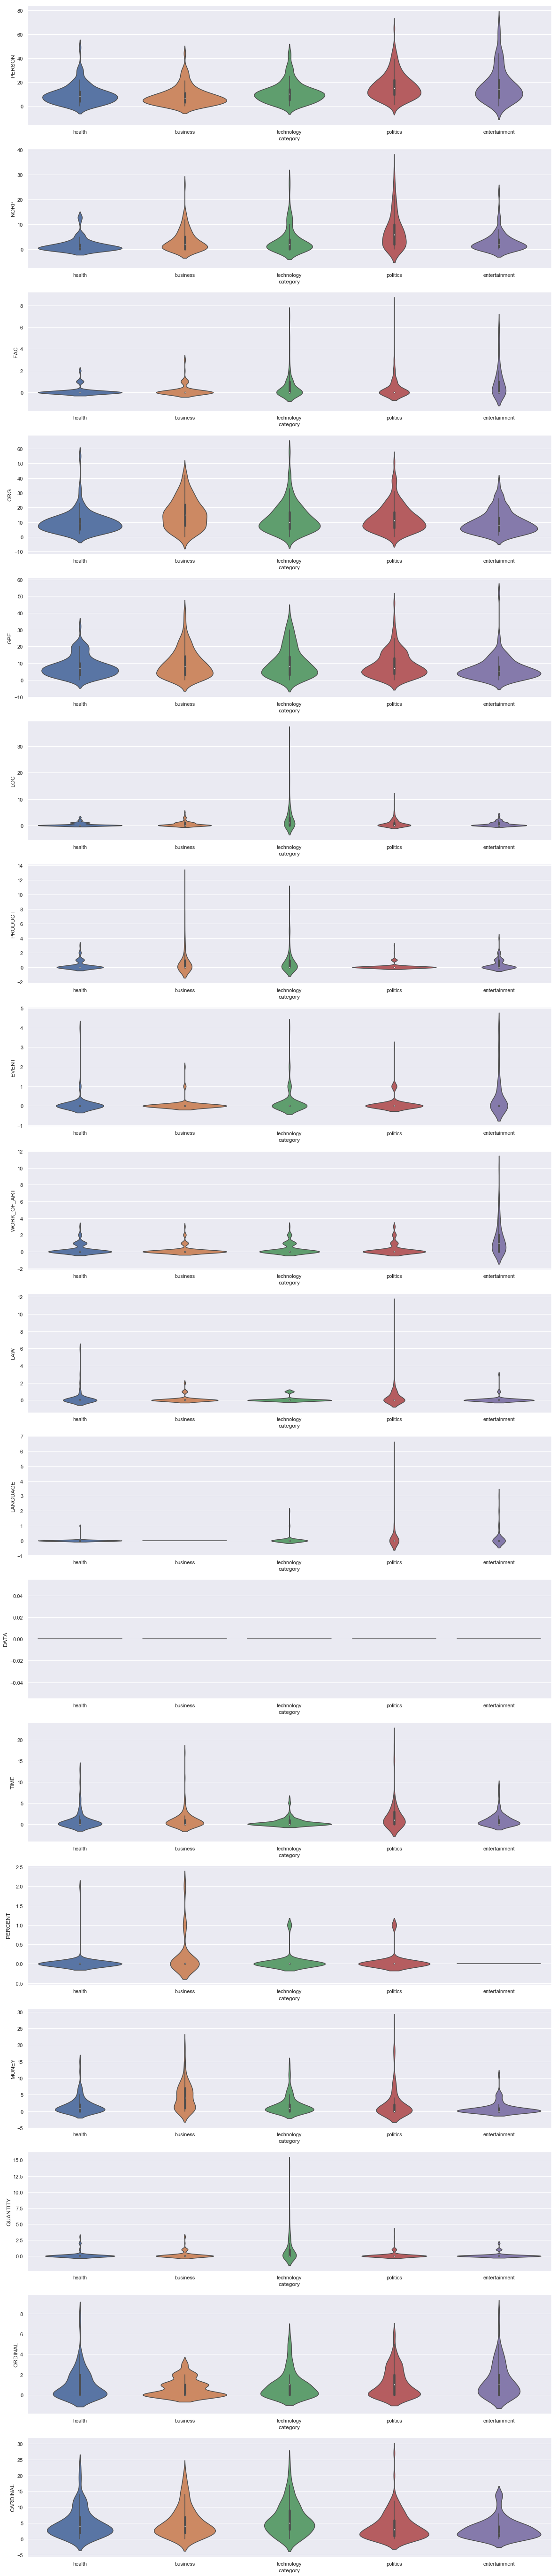

In [27]:
plt.figure(figsize=(20, 100))
for i in range(18):
    plt.subplot(len(entity_list), 1, i+1)
    sns.violinplot(y=df[entity_list[i]], x=df['category'])

It would be nice if we can have a pairplot for these numerical data. Since there are too many columns, for the purpose of visualization we remove the name entities that are rarely used. Precisely, we remove those name entities that are used less than once per article (on average).

In [28]:
entity_remove = []
for name in entity_list:
    if df[name].mean()<1: # Less than once on average
        entity_remove.append(name)

df_remove = df.copy()
df_remove.drop(entity_remove, axis=1, inplace=True)
df_remove.describe()

,length,PERSON,NORP,ORG,GPE,TIME,MONEY,ORDINAL,CARDINAL,polarity,subjectivity
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.00000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,382.523020,12.883978,4.075506,12.327808,8.948435,1.13628,2.248619,1.046041,4.747698,0.091246,0.416493
std,192.571506,10.854089,5.383092,9.199074,7.844729,2.53460,3.547110,1.370383,4.465620,0.071376,0.073394
min,54.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.178125,0.066667
25%,231.000000,6.000000,0.000000,6.000000,3.000000,0.00000,0.000000,0.000000,1.500000,0.049926,0.377915
50%,364.000000,10.000000,2.000000,10.000000,7.000000,0.00000,1.000000,1.000000,4.000000,0.085634,0.419771
75%,495.000000,17.000000,6.000000,17.000000,12.000000,1.00000,3.000000,2.000000,7.000000,0.131247,0.462379
max,1089.000000,68.000000,33.000000,58.000000,52.000000,20.00000,26.000000,8.000000,27.000000,0.470170,0.668872


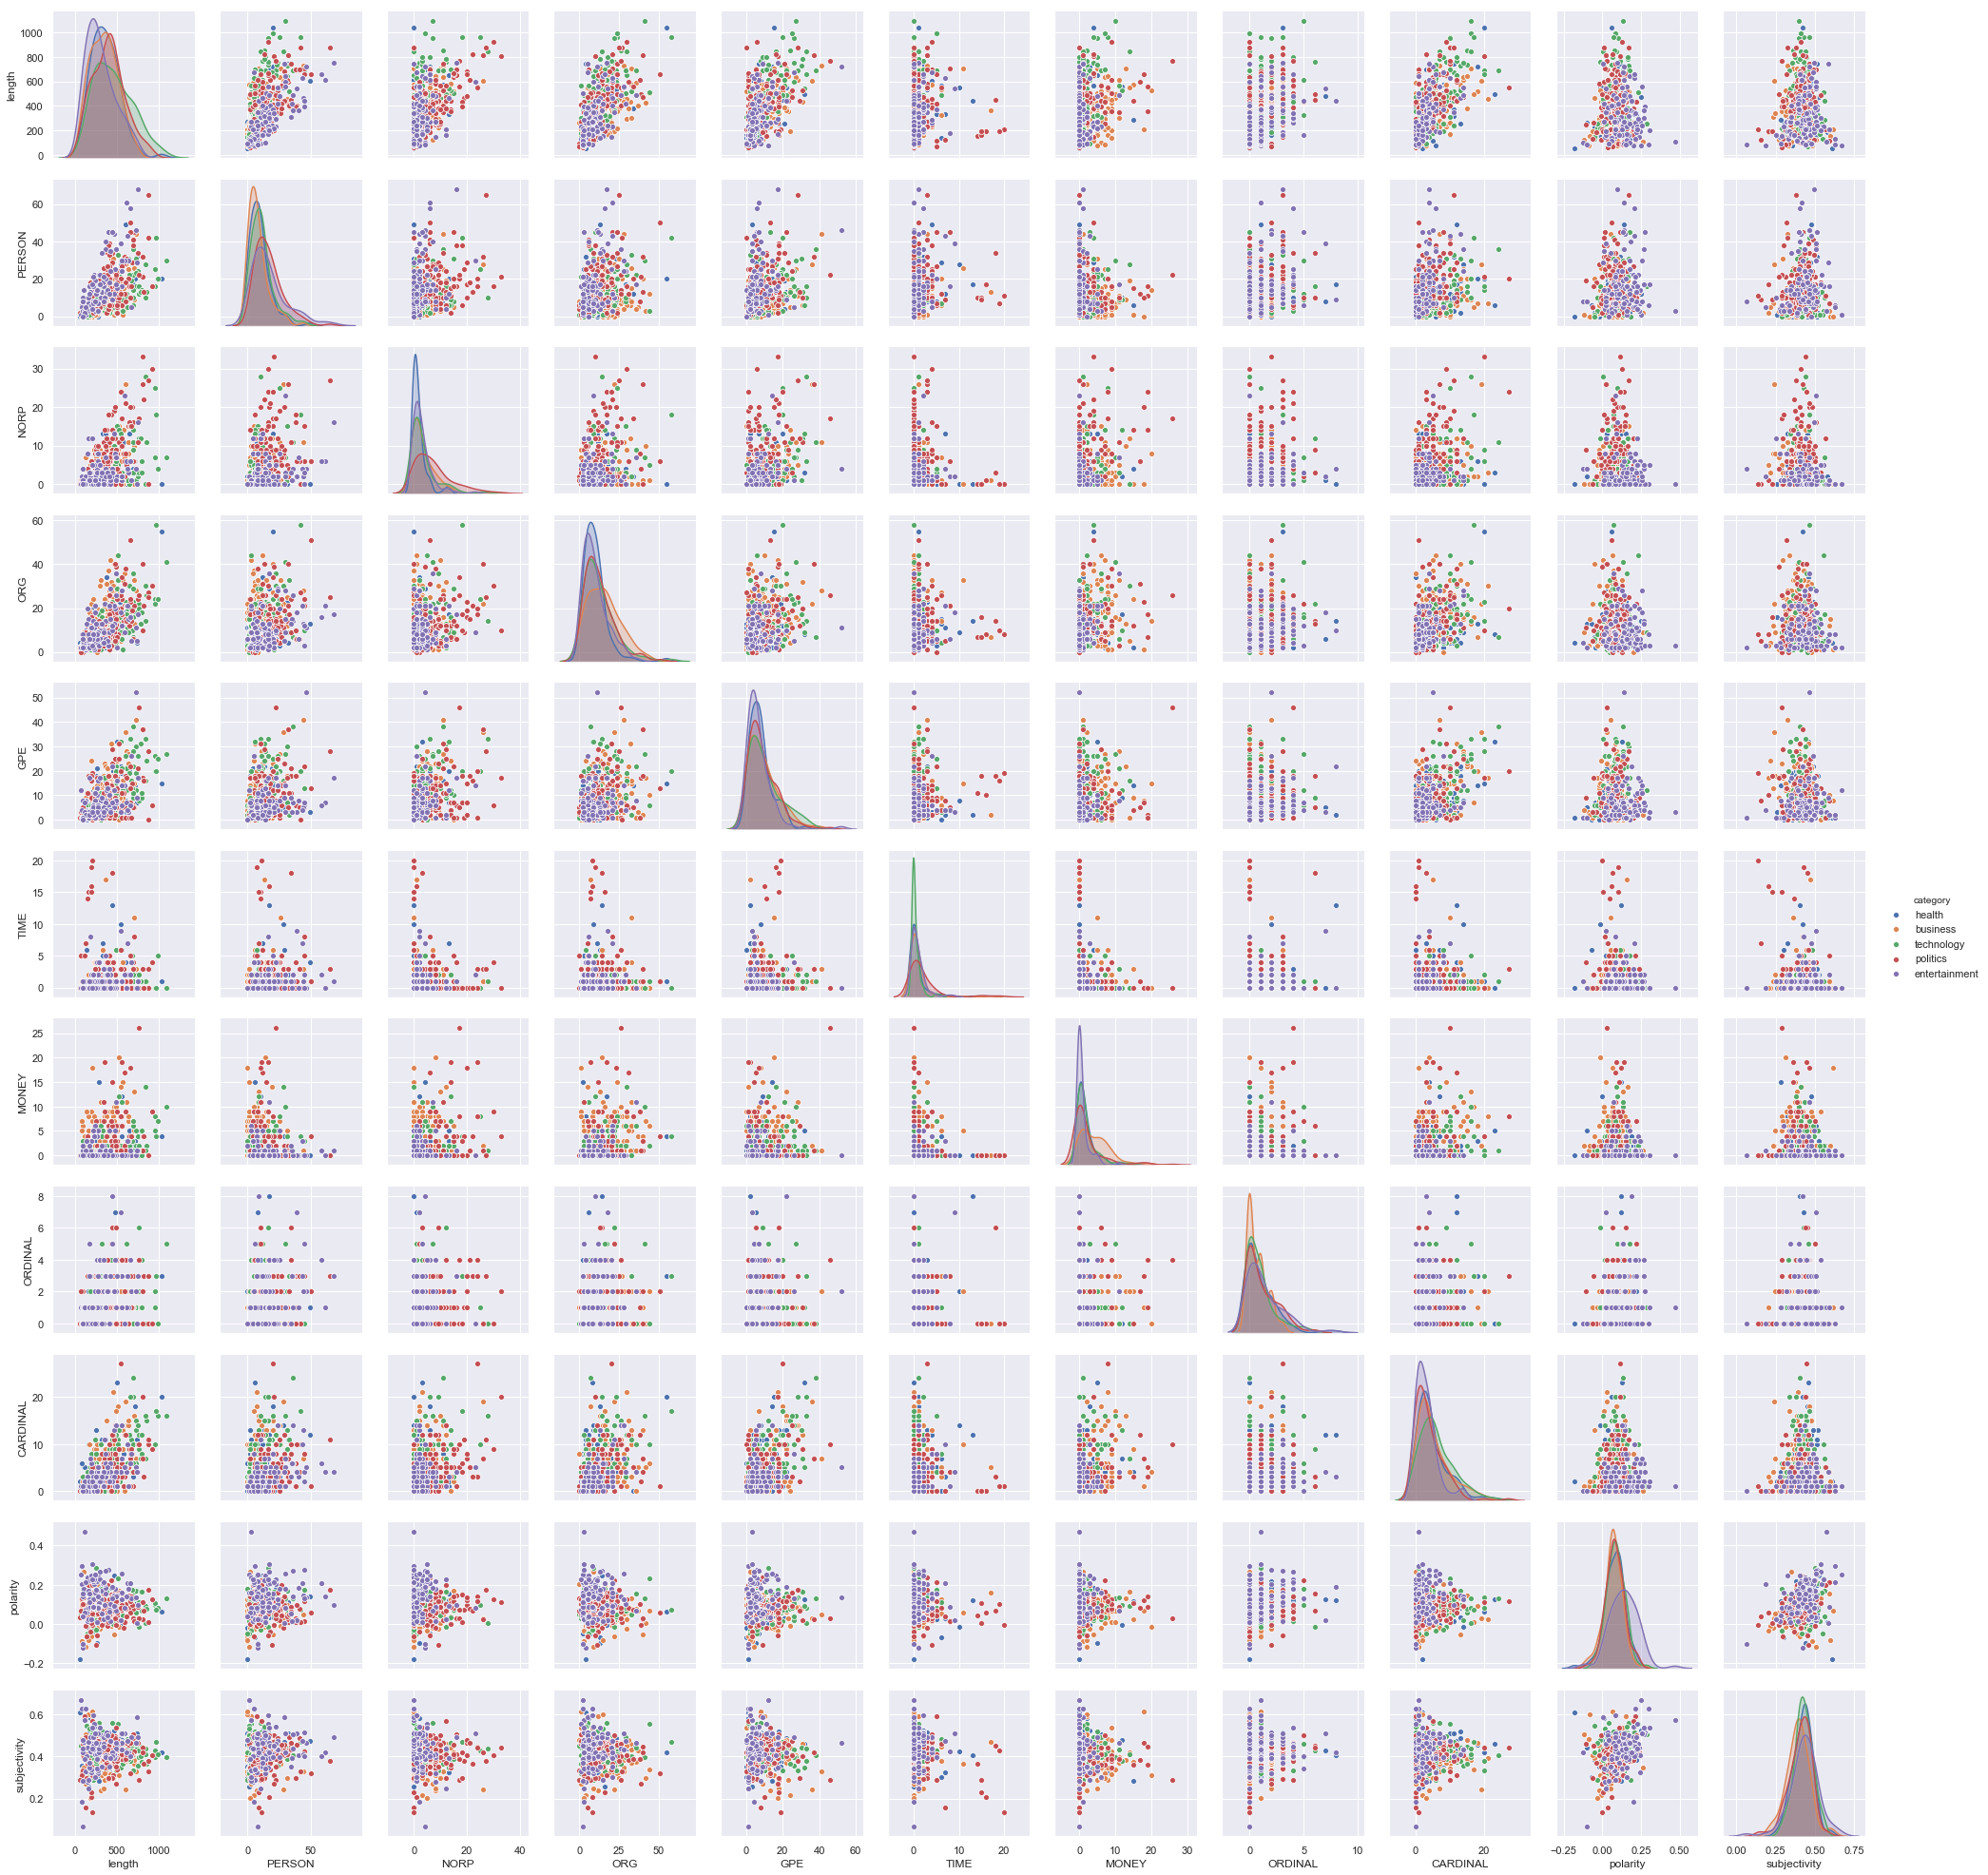

In [29]:
sns.pairplot(df_remove, hue='category');

Apparently, most of the numerical statistics we used fail to separate the five categories. On the other hand, the unigram and bigram distribution are offering much more hope: the five categories are using very different kind of words.

Now we are ready to train various machine learning models and carry out our predictions.

## Text Classification with Basic Characteristics

We will perform our first prediction using only the numerical information (length, polarity, subjectivity, and name entities) It is definitely not a good idea as we do not even consider the content of the articles, but it is interesting to see how far we can get.

For our accuracy measure, we will also study the accuracy for each category to see if the model is good at predicting a particular category. We employ a random forest model and we use a 5-fold cross-validation to compute the accuracy.

In [30]:
characteristics = entity_list + ['length', 'polarity', 'subjectivity']
X = df[characteristics].values
y = df['category'].values

# Splitting training and testing set
kf = KFold(n_splits=5, random_state=1)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)

# Function to calculate accuracy for each category
def confusion_summary(matrix):
    accuracy = []
    for i in range(5):
        m = matrix[:,i]
        accuracy.append(m[i] / np.sum(m))
    return accuracy

# Function for cross-validation
def performance(model, name):
    scores = []
    accuracy_matrix = np.zeros((5,5))
    
    # Cross-Validation
    for index, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        scores.append(accuracy_score(prediction, y_test))
        M = confusion_matrix(prediction, y_test)
        accuracy_matrix[index] = confusion_summary(M)
    
    accuracy = np.mean(accuracy_matrix, axis=0)
    
    print('Overall accuracy of the {0} model: {1:.2f}% \n'.format(name, np.mean(scores)*100))
    print('Accuracy for Business Category: {0:.2f}%'.format(accuracy[0]*100))
    print('Accuracy for Entertainment Category: {0:.2f}%'.format(accuracy[1]*100))
    print('Accuracy for Health Category: {0:.2f}%'.format(accuracy[2]*100))
    print('Accuracy for Politics Category: {0:.2f}%'.format(accuracy[3]*100))
    print('Accuracy for Technology Category: {0:.2f}% \n'.format(accuracy[4]*100))

In [31]:
performance(rf_classifier, 'Random Forest')

Overall accuracy of the Random Forest model: 54.31% 

Accuracy for Business Category: 54.31%
Accuracy for Entertainment Category: 63.68%
Accuracy for Health Category: 44.80%
Accuracy for Politics Category: 65.66%
Accuracy for Technology Category: 47.53% 



The overall accuracy is better than we expected - it is right half of the time without even reading the article! And it performs especially well when it comes to the entertainment or politics category.

## Text Classification with Bag-of-Words

Next, we will perform classification by considering what vocabularies does the article uses. We will employ three different models: logistic regression, support vector machine, and random forest.

In [32]:
tfidf_vector = TfidfVectorizer(stop_words=nlp.Defaults.stop_words, ngram_range=(1,2))

In [33]:
logit_classifier = LogisticRegression(solver='lbfgs', multi_class='auto')
svm_classifier = SVC(kernel='linear', gamma='scale') # default kernel is rbf, but it is not effective here
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=0)

pipe_logit = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', logit_classifier)])

pipe_svm = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', svm_classifier)])

pipe_rf = Pipeline([('vectorizer', tfidf_vector),
                ('classifier', rf_classifier)])

For each model, we will perform a 5-fold cross-validation.

In [34]:
X = df['content cleaned']
y = df['category']

performance(pipe_logit, 'Logistic Regression')
performance(pipe_svm, 'Support Vector Machine')
performance(pipe_rf, 'Random Forest')

Overall accuracy of the Logistic Regression model: 81.20% 

Accuracy for Business Category: 73.33%
Accuracy for Entertainment Category: 84.91%
Accuracy for Health Category: 87.23%
Accuracy for Politics Category: 94.64%
Accuracy for Technology Category: 72.20% 

Overall accuracy of the Support Vector Machine model: 81.94% 

Accuracy for Business Category: 72.96%
Accuracy for Entertainment Category: 88.37%
Accuracy for Health Category: 85.65%
Accuracy for Politics Category: 92.69%
Accuracy for Technology Category: 75.88% 

Overall accuracy of the Random Forest model: 79.00% 

Accuracy for Business Category: 79.22%
Accuracy for Entertainment Category: 87.95%
Accuracy for Health Category: 78.65%
Accuracy for Politics Category: 94.25%
Accuracy for Technology Category: 60.08% 



They all achieve around 80% accuracy for this text classification problem. This is quite impressive since our dataset is really small. Furthermore, the five categories are not mutually exclusive - for example, there might be a news article on the health care policy of the liberal party in the politics section, but our model might put it under the health section.

All models here are good at dealing with the entertainment and politics category. Maybe these two categories are actually easier to detect.

In spite of the excellent accuracy, the bag-of-words approach has a weakness. It does not consider the ordering of the words, and hence it does not really understand the meaning of the passage.

For example, the passage "A new TV series on climate change conspiracy has received critical acclaim. It has been nominated for several prestigious awards." clearly belongs to the entertainment category, but it might be classified to the technology category because it mentions climate change. 

In [35]:
text = ['A new TV series on climate change conspiracy has received critical acclaim. It has been nominated for several prestigious awards.']
print(pipe_logit.predict(text))
print(pipe_svm.predict(text))
print(pipe_rf.predict(text))

['technology']
['technology']
['entertainment']


You might think the random forest model is smarter than the others. This is actually not the case, because:

In [36]:
text = ['climate change']
print(pipe_logit.predict(text))
print(pipe_svm.predict(text))
print(pipe_rf.predict(text))

['technology']
['technology']
['entertainment']


Our random forest model actually thinks climate change is something that belongs to entertainment!

## Text Classification with Word Embeddings

Finally, we will apply the Long Short-Term Memory (LSTM) network to tackle this problem. Unlike the bag-of-words approach, this model is able to understand sentence structure. It turns out that our accuracy does not improve if we use LSTM since the dataset is too small for a deep learning approach, but it can successfully handle the two "misleading" passages we mentioned at the end of the last section.

In [37]:
X = df['content cleaned']
y = pd.get_dummies(df['category'])

Again, we will perform a 5-fold cross-validatoin. The code is a little bit involved due to some incompatability between the `scikit-lean` and `keras` libraries. It consists of four major steps:

1. Use an integer to represent each word.
2. If the article length is less than 600, fill the rest with 0.
3. Use GloVe word embedding from the `spaCy` library to convert each word to a vector
4. Perform LSTM

In [38]:
scores = []
accuracy_matrix = np.zeros((5,5))
column = ['business', 'entertainment', 'health', 'politics', 'technology']

for index, (train_index, test_index) in enumerate(kf.split(X)):
    
    # Splitting up into training sets and testing sets
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Training our tokenizer
    
    t = Tokenizer()
    t.fit_on_texts(X_train)
    vocab_size = len(t.word_index) + 1

    # Use the tokenizer to transform our text data
    # Each word will be represented by an integer
    
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)
    
    # Make every text the same length by inserting zeros
    
    X_train = sequence.pad_sequences(X_train, maxlen=600)
    X_test = sequence.pad_sequences(X_test, maxlen=600)
    
    # Construct a matrix that contains the GloVe word embedding vectors we need
    # Each vector is 300-dimensional
    
    embedding_matrix_spacy = np.zeros((vocab_size, 300))
    for word, i in t.word_index.items():
        embedding_vector = nlp(word).vector
        if embedding_vector is not None:
            embedding_matrix_spacy[i] = embedding_vector
            
    # Setup our LSTM network
    # The first layer (embedding) transforms words (represented by an integer now) to vectors
            
    model_spacy = Sequential()
    model_spacy.add(Embedding(vocab_size,
                              300,
                              weights=[embedding_matrix_spacy],
                              input_length=600,
                              trainable=False))
    model_spacy.add(LSTM(100))
    model_spacy.add(Dense(5, activation='softmax'))
    model_spacy.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])
    
    # Training our network

    model_spacy.fit(X_train,
                    y_train.values,
                    validation_data=(X_test, y_test.values),
                    epochs=30,
                    batch_size=128)
    
    # Make prediction and obtain an array of probability
    # Use np.argmax to get the max probability
    # Then transform "0, 1, 2, 3, 4" to "business, entertainment, health, politics, technology"

    predict_prob = model_spacy.predict(X_test)
    predict_num = np.empty((len(predict_prob),))
    for i in range(len(predict_prob)):
        predict_num[i] = np.argmax(predict_prob[i])
    predict = pd.DataFrame(data=predict_num,
                           index=y_test.index,
                           columns=['category'])
    
    for i in range(len(predict_num)):
        predict.iloc[i] = column[int(predict.iloc[i].values)]
        
    # Undo one-hot encoding for y_test
    
    y_test_compressed = y_test.idxmax(1)
    
    # Calculate accuracy measure
    
    scores.append(accuracy_score(predict, y_test_compressed))
    M = confusion_matrix(predict, y_test_compressed)
    accuracy_matrix[index] = confusion_summary(M)

accuracy = np.mean(accuracy_matrix, axis=0)

Train on 434 samples, validate on 109 samples
Epoch 1/30
434/434 [==============================] - 8s 17ms/sample - loss: 1.5914 - accuracy: 0.2673 - val_loss: 1.5256 - val_accuracy: 0.3670
Epoch 2/30
434/434 [==============================] - 5s 12ms/sample - loss: 1.4426 - accuracy: 0.4171 - val_loss: 1.4359 - val_accuracy: 0.4128
Epoch 3/30
434/434 [==============================] - 5s 13ms/sample - loss: 1.2957 - accuracy: 0.5553 - val_loss: 1.3099 - val_accuracy: 0.5321
Epoch 4/30
434/434 [==============================] - 5s 12ms/sample - loss: 1.1472 - accuracy: 0.6406 - val_loss: 1.1648 - val_accuracy: 0.5963
Epoch 5/30
434/434 [==============================] - 5s 12ms/sample - loss: 0.9786 - accuracy: 0.6935 - val_loss: 1.0499 - val_accuracy: 0.6606
Epoch 6/30
434/434 [==============================] - 5s 12ms/sample - loss: 0.8355 - accuracy: 0.7350 - val_loss: 0.9951 - val_accuracy: 0.6881
Epoch 7/30
434/434 [==============================] - 5s 12ms/sample - loss: 0.6635 

434/434 [==============================] - 6s 13ms/sample - loss: 0.2492 - accuracy: 0.9194 - val_loss: 0.8467 - val_accuracy: 0.7523
Epoch 27/30
434/434 [==============================] - 6s 13ms/sample - loss: 0.2314 - accuracy: 0.9286 - val_loss: 0.9337 - val_accuracy: 0.7064
Epoch 28/30
434/434 [==============================] - 6s 13ms/sample - loss: 0.2547 - accuracy: 0.9240 - val_loss: 0.9302 - val_accuracy: 0.7156
Epoch 29/30
434/434 [==============================] - 6s 13ms/sample - loss: 0.2355 - accuracy: 0.9286 - val_loss: 0.9335 - val_accuracy: 0.7339
Epoch 30/30
434/434 [==============================] - 6s 13ms/sample - loss: 0.2239 - accuracy: 0.9378 - val_loss: 0.9126 - val_accuracy: 0.7431
Train on 434 samples, validate on 109 samples
Epoch 1/30
434/434 [==============================] - 7s 17ms/sample - loss: 1.5933 - accuracy: 0.1889 - val_loss: 1.4901 - val_accuracy: 0.4220
Epoch 2/30
434/434 [==============================] - 6s 13ms/sample - loss: 1.4176 - accur

Epoch 22/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.2262 - accuracy: 0.9264 - val_loss: 0.6583 - val_accuracy: 0.8241
Epoch 23/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.2092 - accuracy: 0.9425 - val_loss: 0.7918 - val_accuracy: 0.7685
Epoch 24/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.1936 - accuracy: 0.9471 - val_loss: 0.8441 - val_accuracy: 0.7315
Epoch 25/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.2056 - accuracy: 0.9517 - val_loss: 0.7823 - val_accuracy: 0.7963
Epoch 26/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.1832 - accuracy: 0.9563 - val_loss: 0.7737 - val_accuracy: 0.8056
Epoch 27/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.1587 - accuracy: 0.9448 - val_loss: 0.8323 - val_accuracy: 0.7778
Epoch 28/30
435/435 [==============================] - 6s 13ms/sample - loss: 0.1810 - accuracy: 0.9517 - val_loss: 0.8647 -

In [39]:
print('Overall accuracy of the LSTM model: {0:.2f}% \n'.format(np.mean(scores)*100))
print('Accuracy for Business Category: {0:.2f}%'.format(accuracy[0]*100))
print('Accuracy for Entertainment Category: {0:.2f}%'.format(accuracy[1]*100))
print('Accuracy for Health Category: {0:.2f}%'.format(accuracy[2]*100))
print('Accuracy for Politics Category: {0:.2f}%'.format(accuracy[3]*100))
print('Accuracy for Technology Category: {0:.2f}% \n'.format(accuracy[4]*100))

Overall accuracy of the LSTM model: 73.65% 

Accuracy for Business Category: 66.03%
Accuracy for Entertainment Category: 84.62%
Accuracy for Health Category: 83.28%
Accuracy for Politics Category: 80.71%
Accuracy for Technology Category: 66.42% 



It achieves an overall accuracy of 74.04%, again with better performance on the entertainment and politics category. The model should perform much better if we have a larger dataset that has, say, more than 2000 articles.

Finally, let's check if the model can tell the difference between a TV series about climate change and climate change itself.

In [40]:
text = ['A new TV series on climate change conspiracy has received critical acclaim. It has been nominated for several prestigious awards.']
text = t.texts_to_sequences(text)
text = sequence.pad_sequences(text, maxlen=600)

prob = model_spacy.predict(text)
column[np.argmax(prob)]

'entertainment'

In [41]:
text = ['climate change']
text = t.texts_to_sequences(text)
text = sequence.pad_sequences(text, maxlen=600)

prob = model_spacy.predict(text)
column[np.argmax(prob)]

'technology'

It passes the test! LSTM is able to "remember" the early information (TV series) and use it for prediction after reading the whole passage.

So thank you for reading! If you have any comment on how this notebook can be improved, please let me know.